In [1]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../Data/hindi_train.csv")
data

,Id,Heading,Summary,Article
0,hindi_2023_train_0,"गला दबाकर हत्या की; बॉडी बोरे में भरी, लोकल मा...",Kerala Minor Girl Rape Case - केरल के एर्नाकुल...,केरल के एर्नाकुलम जिले में 5 साल की बच्ची से र...
1,hindi_2023_train_1,तेलंगाना में 18 की जान गई; जम्मू-कश्मीर में बा...,इस साल मानसून सीजन में कई राज्यों में भारी तबा...,मानसून सीजन में हुई भारी बारिश ने कई राज्यों म...
2,hindi_2023_train_2,"राजस्थान सरकार बनाएगी कर्ज राहत आयोग, कोर्ट के...",चुनावी साल में राजस्थान सरकार किसानों को लुभान...,चुनावी साल में राजस्थान सरकार किसानों को लुभान...
3,hindi_2023_train_3,"3 से 7 अगस्त तक कर सकेंगे अप्लाय, प्राइस बैंड ...",Non-banking lender SBFC Finance's initial publ...,नॉन बैंकिग फाइनेंस कंपनी 'SBFC फाइनेंस लिमिटेड...
4,hindi_2023_train_4,"डाइनिंग टेबल पर कुकर-कड़ाही न सजाएं, चीन के खा...",स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...
...,...,...,...,...
21220,hindi_2022_11363,"MSP पर प्रधानमंत्री ने कमेटी बनाई, पराली जलाना...","कृषि मंत्री ने कहा, तीनों कृषि कानूनों को वापस...",नई दिल्ली: कृषि मंत्री नरेंद्र सिंह तोमर ने एम...
21221,hindi_2022_11364,"योगी सरकार ने 9 गेस्ट हाउस का नाम नदियों, धार्...",मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...,लखनऊ: उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने ...
21222,hindi_2022_11365,"Coronavirus से कुछ राहत, 7 लाख के नीचे आए एक्ट...",केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...,नई दिल्ली। कोरोना वायरस को लेकर कुछ राहत की बा...
21223,hindi_2022_11366,"वाराणसी गंगा नदी के किनारे सबसे साफ शहर बना, प...",लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...,नई दिल्ली: केंद्रीय शहरी विकास मंत्री हरदीप सि...


In [3]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)
print("Training Set:")
print(train_data.shape)
print("Validation Set:")
print(val_data.shape)

Training Set:
(18041, 4)
Validation Set:
(3184, 4)


In [4]:
import re

def preprocess_tokenize(text):
    # for removing punctuation from sentencesc
    text = str(text)
    # text = re.sub(r'(\d+)', r'', text) # remove numbers
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\u200d', '') #
    text = re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively
    text = re.sub(r"[&©@#ø;.~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!
    # text = re.sub(r"[‘’।:]", " ", str(text)) #removing other special characters
    # text = re.sub("([a-zA-Z])",' ',str(text)).lower() #removing all the single characters
    text = re.sub("(\s+)",' ',str(text)).lower() #removing extra spaces
    return text

train_text = [preprocess_tokenize(text) for text in train_data['Article']]
train_summary = [preprocess_tokenize(text) for text in train_data['Summary']]
train_heading = [preprocess_tokenize(text) for text in train_data['Heading']]
val_text = [preprocess_tokenize(text) for text in val_data['Article']]
val_summary = [preprocess_tokenize(text) for text in val_data['Summary']]
val_heading = [preprocess_tokenize(text) for text in val_data['Heading']]

In [5]:
import torch
from transformers import EncoderDecoderModel, AutoTokenizer, AutoModelForCausalLM,AutoModelForSeq2SeqLM, MT5ForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_encoder = AutoTokenizer.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum") #"aashay96/indic-gpt"
tokenizer_decoder = AutoTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

decoder_model = MT5ForConditionalGeneration.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_decoder()
encoder_model =  AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_encoder()

model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model=encoder_model, decoder_pretrained_model_name_or_path="ai4bharat/IndicBART")
model.config.decoder_start_token_id = tokenizer_encoder.pad_token_id
model.config.pad_token_id = tokenizer_encoder.pad_token_id
tokenizer_encoder.add_tokens(["<sum>"], special_tokens=True )
model = model.to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
train = iter(train_heading[i] + train_text[i] for i in range(len(train_text)))
new_tokenizer = tokenizer_encoder.train_new_from_iterator(train, vocab_size=10000)
new_tokens = set(new_tokenizer.vocab) - set(tokenizer_encoder.vocab)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [7]:
len(new_tokenizer.vocab)

10000

In [8]:
tokenizer_encoder.add_tokens(list(new_tokens))

8261

In [9]:
model.decoder.resize_token_embeddings(len(tokenizer_encoder))
#model.resize_token_embeddings(len(tokenizer_encoder))
model.encoder.resize_token_embeddings(len(tokenizer_encoder))


Embedding(258362, 768)

In [10]:
model

EncoderDecoderModel(
  (encoder): MT5Stack(
    (embed_tokens): Embedding(258362, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_fea

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 3

In [12]:
def fine_tune(model, tokenizer_enc, tokenizer_dec, train_heading, train_text, train_summary, 
        optimizer, device, print_every=1000):
    model.train()
    model = model.to(device)
    total_loss = 0
    item_num = 0
    batch_loss = 0
    for heading, text, summary in zip(train_heading, train_text, train_summary):
        input = tokenizer_enc("<sum>" + heading + " " + text, return_tensors="pt", max_length=512, truncation=True)
        input_ids = input.input_ids.to(device)
        attention_mask = input.attention_mask.to(device)
        labels = tokenizer_dec(summary, max_length=240, truncation=True, return_tensors="pt")
        labels_input_ids = labels.input_ids.to(device)
        labels_attention_mask = labels.attention_mask.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask,  
                    labels=labels_input_ids, decoder_attention_mask=labels_attention_mask)
        loss = outputs.loss
        total_loss += loss.item()
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        item_num += 1
        if item_num % print_every == 0:
            print(f"Processed: {item_num}/{len(train_text)} Loss: {batch_loss/print_every}")
            batch_loss = 0
    return total_loss / len(train_text)
        

def evaluate(model, tokenizer_enc, tokenizer_dec, val_heading, val_text, val_summary, device):
    model.eval()
    model = model.to(device)
    total_loss = 0
    item_num = 0
    with torch.no_grad():
        for heading, text, summary in zip(val_heading, val_text, val_summary):
            input = tokenizer_enc("<sum>" + heading + " " + text, return_tensors="pt", max_length=512, truncation=True)
            input_ids = input.input_ids.to(device)
            attention_mask = input.attention_mask.to(device)
            labels = tokenizer_dec(summary, max_length=240, truncation=True, return_tensors="pt")
            labels_input_ids = labels.input_ids.to(device)
            labels_attention_mask = labels.attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,  
                        labels=labels_input_ids, decoder_attention_mask=labels_attention_mask)
            loss = outputs.loss
            total_loss += loss.item()
            item_num += 1
    return total_loss / len(val_text)

In [13]:
min_val_loss = None
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = fine_tune(model, tokenizer_encoder, tokenizer_decoder, train_heading, train_text, train_summary, 
                    optimizer, device, print_every=1000)
    print(f"==> Epoch {epoch + 1} Train Loss: {train_loss:.4f}")
    val_loss = evaluate(model, tokenizer_encoder, tokenizer_decoder, val_heading, val_text, val_summary, device)
    print(f"==> Epoch {epoch + 1} Validation Loss: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if min_val_loss is None or val_loss < min_val_loss:
        min_val_loss = val_loss
        model = model.to("cpu")
        torch.save(model.state_dict(), "summary_model_enc_dec_old.pth")

Processed: 1000/18041 Loss: 4.2598680787086485
Processed: 2000/18041 Loss: 3.9369308243989947
Processed: 3000/18041 Loss: 3.8945709116458893
Processed: 4000/18041 Loss: 3.7511517816185953
Processed: 5000/18041 Loss: 3.7865954553484915
Processed: 6000/18041 Loss: 3.723085034966469
Processed: 7000/18041 Loss: 3.679088973224163
Processed: 8000/18041 Loss: 3.672015278637409
Processed: 9000/18041 Loss: 3.7116458378136157
Processed: 10000/18041 Loss: 3.644479964315891
Processed: 11000/18041 Loss: 3.6334243168234823
Processed: 12000/18041 Loss: 3.696839250385761
Processed: 13000/18041 Loss: 3.66506893491745
Processed: 14000/18041 Loss: 3.6408844261169433
Processed: 15000/18041 Loss: 3.6420344811081886
Processed: 16000/18041 Loss: 3.6084347073882816
Processed: 17000/18041 Loss: 3.6008109023571016
Processed: 18000/18041 Loss: 3.623976671040058
==> Epoch 1 Train Loss: 3.7316
==> Epoch 1 Validation Loss: 3.4036
Processed: 1000/18041 Loss: 3.3082803460657595
Processed: 2000/18041 Loss: 3.315891837

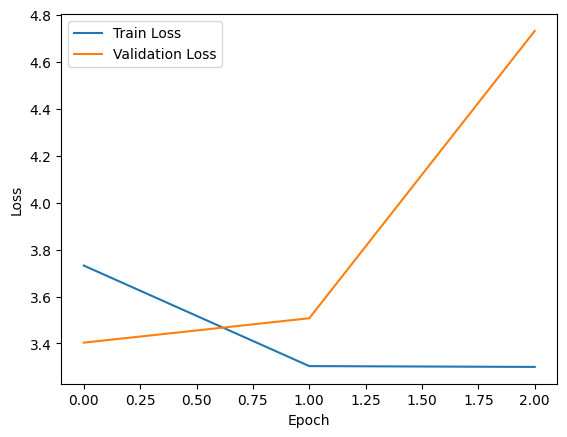

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
ind = 0
head_text = val_heading[ind]
article_text = val_text[ind]
summary_text = val_summary[ind]
inputs = tokenizer_encoder("<sum>" + head_text + " " + article_text, return_tensors="pt", max_length=1024, truncation=True).to(device)
labels = tokenizer_decoder(summary_text, max_length=240, truncation=True, return_tensors="pt").to(device)

outputs = model(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, labels=labels.input_ids, decoder_attention_mask=labels.attention_mask)
outputs.loss

tensor(4.6929, device='cuda:0', grad_fn=<NllLossBackward0>)

In [17]:
ind = 0
head_text = val_heading[ind]
article_text = val_text[ind]
summary_text = val_summary[ind]

input_ids = tokenizer_encoder("<sum>" + head_text + article_text, max_length=1024, truncation=True, return_tensors="pt").to(device)
outputs = model.generate(inputs=input_ids.input_ids, attention_mask=input_ids.attention_mask, decoder_start_token_id=model.config.decoder_start_token_id, num_beams=4)
summary = tokenizer_decoder.decode(outputs[0], skip_special_tokens=True, predict_with_generate=True)
print(outputs)
print("Summary:", summary)

tensor([[    0,   218,    31, 40775, 27559, 13772,    13, 31083, 12497,    13,
          2851,   463,   803,    34,  3615,  3162, 18498,    15,     8,     2]],
       device='cuda:0')
Summary: देश में कोरोना वायरस संक्रमण के बढ़ते मामलों के देखते हुए केंद्र ने बड़ा कदम उठाया है।


# Load the saved Model

In [6]:
import torch
from transformers import EncoderDecoderModel, AutoTokenizer, AutoModelForCausalLM,AutoModelForSeq2SeqLM, MT5ForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the tokenizer and model for encoder and decoder
tokenizer_encoder = AutoTokenizer.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum") #"aashay96/indic-gpt"
tokenizer_decoder = AutoTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

# Load the pre-trained model for encoder and decoder
decoder_model = MT5ForConditionalGeneration.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_decoder()
encoder_model =  AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_m2o_hindi_crossSum").get_encoder()

# Initialize the encoder-decoder model
loaded_model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model=encoder_model, decoder_pretrained_model_name_or_path="ai4bharat/IndicBART")
loaded_model.config.decoder_start_token_id = tokenizer_encoder.pad_token_id
loaded_model.config.pad_token_id = tokenizer_encoder.pad_token_id
tokenizer_encoder.add_tokens(["<sum>"], special_tokens=True )
loaded_model = loaded_model.to(device)

# Add the new tokens to the tokenizer
train = iter(train_heading[i] + train_text[i] for i in range(len(train_text)))
new_tokenizer = tokenizer_encoder.train_new_from_iterator(train, vocab_size=10000)
new_tokens = set(new_tokenizer.vocab) - set(tokenizer_encoder.vocab)
tokenizer_encoder.add_tokens(list(new_tokens))

# Resize the token embeddings
loaded_model.decoder.resize_token_embeddings(len(tokenizer_encoder))
loaded_model.encoder.resize_token_embeddings(len(tokenizer_encoder))

# Load the pre-trained loaded_model
loaded_model.load_state_dict(torch.load("summary_model_enc_dec_old.pth"))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<All keys matched successfully>

In [13]:
ind = 0
head_text = val_heading[ind]
article_text = val_text[ind]
summary_text = val_summary[ind]

print("Heading:", head_text)
print("Article:", article_text)
print("Summary:", summary_text)
input_ids = tokenizer_encoder("<sum>" + head_text + article_text, max_length=1024, truncation=True, return_tensors="pt").to(device)
outputs = loaded_model.generate(inputs=input_ids.input_ids, attention_mask=input_ids.attention_mask, decoder_start_token_id=loaded_model.config.decoder_start_token_id, num_beams=4)
summary = tokenizer_decoder.decode(outputs[0], skip_special_tokens=True, predict_with_generate=True)
print(outputs)
print("Summary:", summary)

Heading: मथुरा में सवारियों के रूप में चढ़े बदमाशों ने यमुना एक्सप्रेस-वे पर बस यात्रियों से लाखों रुपये की लूटपाट की
Article: मथुरा: उत्तर प्रदेश के मथुरा जिले में यमुना एक्सप्रेस-वे पर आधा दर्जन बदमाशों ने दिल्ली से हमीरपुर जा रही निजी बस में सवारी के रूप में चढ़कर उसे बंधक बना लिया और तकरीबन सभी सवारियों से लाखों रुपये का सामान लूट किया। घटना की जानकारी मिलने पर आगरा रेंज के पुलिस महानिरीक्षक समेत तमाम वरिष्ठ अधिकारी मौके पर पहुंचे। पुलिस बदमाशों की खोज में जुट गई है। पुलिस के मुताबिक, लूट की घटना उस समय घटी जब बीती रात दिल्ली से हमीरपुर के लिए निकली निजी बस करीब एक बजे नोएडा क्षेत्र से आगे मथुरा जिले की सुरीर कोतवाली क्षेत्र में पहुंची। पुलिस के मुताबिक, बदमाश सवारियों के रूप में बस में चढ़े थे और उन्होंने कुछ समय के बाद ही हथियारों के बल पर बस को बंधक बना लिया और सवारियों से नकदी व जेवर लूट लिए। घटना को अंजाम देने के बाद बदमाश जब बस से उतरकर फरार हो गए तो चालक ने पुलिस को सूचना दी। बस लूट की जानकारी मिलने पर आईजी नवीन अरोड़ा, एसएसपी डॉ गौरव ग्रोवर मौके पर पहुंच गए। एसएसपी डॉ गौरव ग्र